In [1]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile
import pickle
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import colorlover as cl


import neuro_morpho_toolbox as nmt
%matplotlib inline
import pickle
pickle_in = open("/home/penglab/FeaCal/all_ns.pickle","rb")
[ns] = pickle.load(pickle_in)


/home/penglab/anaconda3/lib/python3.7/site-packages/neuro_morpho_toolbox-0.1-py3.7.egg/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.77
Loading CCF brain structure data...
Loading time: 0.00


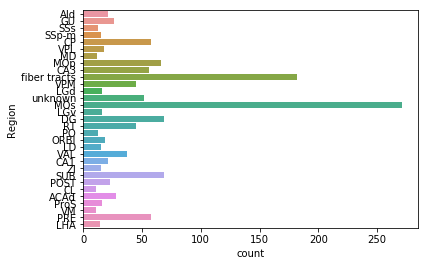

In [3]:
sf = ns.features['soma_features'].region
ct = sf["Region"].value_counts().sort_values(ascending=False)
_ = sns.countplot(y="Region", 
                  data=sf.loc[sf.Region.isin(ct.index[ct>10])],
                 )

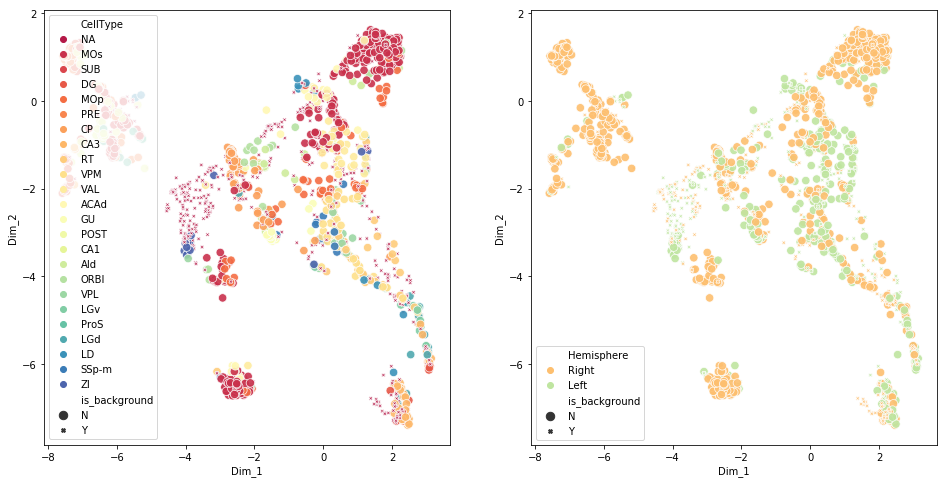

In [4]:
_ = ns.ReduceDimUMAP(feature_set="soma_features", n_neighbors=100)
_ = ns.FeatureScatter(["CellType", "Hemisphere"], map="UMAP")

### Generate the dataframe in pickCLUSTERpara(method)

In [5]:
import pickle
pickle_in = open("/home/penglab/NMTcode/selectedDF.pickle","rb")
[selectedDF] = pickle.load(pickle_in)


In [6]:
from sklearn import metrics
from random import randrange
def pickCLUSTERpara(method,selected_list):
    if len(selected_list) >0:
        print('Will calculate ARI for '+ str(len(selected_list) ) + ' neurons')
    result_DF = pd.DataFrame()
    method_list = ['kmeans','snn','hdbscan','hierarchy','dbscan']
    assert method in method_list, "Should be one of "+str(method_list)
    colname = ['ARI','NumCluster','parameter']
    if method.lower() == 'hierarchy':
        #%% Store the result of Hierarchy
        result_hier = pd.DataFrame(columns = colname)
        L_method_list=['single', 'complete','average','weighted','centroid','median','ward']
        L_metric_list=['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine',
                       'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski', 
                       'mahalanobis', 'matching','minkowski','rogerstanimoto', 'russellrao',
                       'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean']

        criterionH_list=['inconsistent','distance','maxclust','monocrit','maxclust_monocrit']

        hier_dict={'L_method':'single', 'L_metric':'euclidean','criterionH':'inconsistent', 'depth':2,'R':None,
                   't':0.9,'optimal_ordering':False,'colR':3}
        for L_methodidx in L_method_list:
            hier_dict.update(L_method = L_methodidx)
            for L_metricidx in L_metric_list:
                hier_dict.update(L_metric = L_metricidx )
                # so far the parameter to generate the linkage array is set
                if L_methodidx == 'centroid' or L_methodidx == 'median' or L_methodidx == 'ward':
                    if L_metricidx != 'euclidean':
                        continue         
                for criterionidx in criterionH_list:
                    hier_dict.update(criterionH = criterionidx )   
                    if criterionidx == 'inconsistent' or criterionidx == 'distance':
                        for t_iter in  np.arange(0,1.6,0.05)  : 
                            hier_dict.update(t = t_iter) 
                            if criterionidx == 'inconsistent':
                                for depth_iter in range(2,16):
                                    hier_dict.update(depth = depth_iter) 
                                    _ = ns. get_clusters(method='Hierarchy',karg_dict=hier_dict)
                                    if len(selected_list)==0:
                                        selected_list = ns.metadata.index.tolist()
                                    tempARI = metrics.adjusted_rand_score(ns.metadata.loc[selected_list,'CellType'],
                                                                          ns.metadata.loc[selected_list,'Cluster'])
                                    tempDF = pd.DataFrame([tempARI, 
                                                           len(list(ns.metadata.groupby('Cluster'))),
                                                           str(hier_dict)]).T.copy()
                                    tempDF.columns=colname
                                    print(str(hier_dict))
                                    result_hier = result_hier.append(tempDF) 
                            elif criterionidx == 'distance':
                                _ = ns. get_clusters(method='Hierarchy',karg_dict=hier_dict)
                                tempARI = metrics.adjusted_rand_score(ns.metadata.loc[selected_list,'CellType'],
                                                                          ns.metadata.loc[selected_list,'Cluster'])
                                tempDF = pd.DataFrame([tempARI, 
                                                       len(list(ns.metadata.groupby('Cluster'))),
                                                       str(hier_dict)]).T.copy()
                                tempDF.columns=colname
                                print(str(hier_dict))
                                result_hier = result_hier.append(tempDF) 
                    if criterionidx == 'maxclust' or criterionidx == 'maxclust_monocrit':
                        for t_iter in  range(20,51): 
                            hier_dict.update(t = t_iter) 
                            _ = ns. get_clusters(method='Hierarchy',karg_dict=hier_dict)
                            tempARI = metrics.adjusted_rand_score(ns.metadata.loc[selected_list,'CellType'],
                                                                          ns.metadata.loc[selected_list,'Cluster'])
                            tempDF = pd.DataFrame([tempARI, 
                                                   len(list(ns.metadata.groupby('Cluster'))),
                                                   str(hier_dict)]).T.copy()
                            tempDF.columns=colname
                            print(str(hier_dict))
                            result_hier = result_hier.append(tempDF) 
                               
        idx_hier = ['Hier'+str(x) for x in range(result_hier.shape[0])]    
        result_hier['idx'] = idx_hier
        result_hier.set_index('idx',inplace=True)  
        result_DF = result_hier.copy()
        
    if method.lower() == 'kmeans':
        result_kmeans = pd.DataFrame(columns = colname)
        init_list=['k-means++','random']
        algorithm_list = ['auto','full','elkan']
        precompute_distances_list = ['auto', True, False]
        n_init_list=['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine',
                       'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski', 
                       'mahalanobis', 'matching','minkowski','rogerstanimoto', 'russellrao',
                       'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean']
        criterionH_list='inconsistent','distance','maxclust','monocrit','maxclust_monocrit'
        kmeans_dict={'n_clusters':20, 'init':'k-means++', 'n_init':10, 'max_iter':300, 'tol':0.0001,
                     'precompute_distances':'auto', 'verbose':0, 'random_state':None,'copy_x': True,
                     'n_jobs':12, 'algorithm':'auto'}
        for init_idx in init_list:
            kmeans_dict.update(init = init_idx)
            for algorithm_idx in algorithm_list:
                kmeans_dict.update(algorithm = algorithm_idx )
                for precompute_distances_idx in precompute_distances_list:
                    kmeans_dict.update(precompute_distances = precompute_distances_idx )
                    for n_clustersidx in range(3,45):
                        kmeans_dict.update(n_clusters = n_clustersidx)     
                        for n_initidx in range(7,15):
                            kmeans_dict.update(n_init = n_initidx) 
                            for tol_idx in np.exp(-np.arange(2,4,0.2)):
                                kmeans_dict.update(tol = tol_idx) 
                                print(kmeans_dict)
                                _ = ns. get_clusters(method='Kmeans',karg_dict=kmeans_dict)
                                tempARI = metrics.adjusted_rand_score(ns.metadata.loc[selected_list,'CellType'],
                                                                          ns.metadata.loc[selected_list,'Cluster'])
                                tempDF = pd.DataFrame([tempARI, 
                                                       len(list(ns.metadata.groupby('Cluster'))),
                                                       str(kmeans_dict)]).T.copy()
                                tempDF.columns=colname
                                print(str(kmeans_dict))
                                result_kmeans = result_kmeans.append(tempDF)         
        idx_kmeans = ['KMeans'+str(x) for x in range(result_kmeans.shape[0])]    
        result_kmeans['idx'] = idx_kmeans
        result_kmeans.set_index('idx',inplace=True)       
        result_DF = result_kmeans.copy()
        
    if method.lower() == 'dbscan':
        result_dbscan = pd.DataFrame(columns = colname)
        algorithm_list = ['auto','ball_tree', 'kd_tree', 'brute']# 
         #
        metriclist = [ 'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation','euclidean', 'cosine',
                      'dice','hamming', 'jaccard', 'kulsinski', 'matching','minkowski','rogerstanimoto','russellrao','sokalmichener', 'sokalsneath']
        dbscan_dict={'eps':20, 'min_samples':5, 'metric':'euclidean','metric_params':None, 'algorithm':'auto', 
                     'leaf_size':30, 'p':None,'n_jobs':12}
        for algorithm_idx in algorithm_list:
            dbscan_dict.update(algorithm = algorithm_idx )
            for metric_iter in metriclist:
                dbscan_dict.update(metric= metric_iter)
                if algorithm_idx == 'ball_tree' and metric_iter in ['correlation','cosine','sqeuclidean']:
                    continue
                if algorithm_idx == 'kd_tree' and metric_iter not in ['chebyshev', 'cityblock', 'euclidean',
                                                                                   'infinity', 'l1', 'l2', 'manhattan',
                                                                                  'minkowski', 'p']:
                    continue
                if algorithm_idx == 'brute' and metric_iter in ['haversine','wminkowski', 'mahalanobis','infinity']:
                    continue
                if metric_iter in ['wminkowski', 'minkowski']:
                    p_iter =randrange(1,10)
                    dbscan_dict.update(p = p_iter)
                    while metric_iter == 'minkowski' and p_iter == 1:
                        p_iter =randrange(2,10)
                        dbscan_dict.update(p = p_iter)
                for epsidx in np.exp(-np.arange(0,4,0.5)):
                    dbscan_dict.update(eps = epsidx)
                    for min_samples_iter in range(5,10):
                        dbscan_dict.update(min_samples = min_samples_iter)
                        for leaf_size_iter in range(25,35):
                            dbscan_dict.update(leaf_size = leaf_size_iter)
                            _ = ns. get_clusters(method='DBSCAN',karg_dict=dbscan_dict)
                            tempARI = metrics.adjusted_rand_score(ns.metadata.loc[selected_list,'CellType'],
                                                                          ns.metadata.loc[selected_list,'Cluster'])
                            tempDF = pd.DataFrame([tempARI, len(list(ns.metadata.groupby('Cluster'))),str(dbscan_dict)]).T.copy()
                            tempDF.columns=colname
                            print(str(dbscan_dict))
                            result_dbscan = result_dbscan.append(tempDF)        
        idx_dbscan = ['DBSCAN'+str(x) for x in range(result_dbscan.shape[0])]    
        result_dbscan['idx'] = idx_dbscan
        result_dbscan.set_index('idx',inplace=True)     
        result_DF = result_dbscan.copy()
        
    if method.lower() == 'hdbscan':
        result_hdbscan = pd.DataFrame(columns = colname)
        #
        metric_list = [ 'euclidean','minkowski', 'l2', 'l1', 'manhattan', 'cityblock', 'braycurtis', 'canberra',
                       'chebyshev','correlation','dice', 'hamming', 'jaccard','kulsinski', 'matching', 
                       'rogerstanimoto', 'russellrao','sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']
        
    
        algorithm_list = ['best', 'generic','prims_kdtree','boruvka_kdtree']#, 
        cluster_selection_method_list = ['leaf','eom']
        hdbscan_dict={'min_cluster_size':5, 'metric':'euclidean','alpha':1.0, 'min_samples':1,
                      'p':2,'algorithm':'best', 'leaf_size':40, 'approx_min_span_tree':True,
                      'gen_min_span_tree':False,'core_dist_n_jobs':4,'cluster_selection_method':'eom',
                      'allow_single_cluster': False,'prediction_data':False,
                      'match_reference_implementation':False}

        for algorithm_idx in algorithm_list:
            hdbscan_dict.update(algorithm = algorithm_idx)
            for metric_idx in metric_list:
                if algorithm_idx=='boruvka_kdtree' and metric_idx in['braycurtis','canberra','dice','hamming',
                                                                     'jaccard','kulsinski','matching','rogerstanimoto',
                                                                     'russellrao','sokalmichener', 'sokalsneath']:
                    continue
                hdbscan_dict.update(metric = metric_idx)
                for cluster_selection_method_idx in cluster_selection_method_list:
                    hdbscan_dict.update(cluster_selection_method = cluster_selection_method_idx )
                    for alpha_idx in np.arange(0.8,1.5,0.1):
                        hdbscan_dict.update(alpha = alpha_idx)
                        for min_samples_iter in range(1,10):
                            hdbscan_dict.update(min_samples = min_samples_iter)
                            #print(hdbscan_dict)
                            _ = ns. get_clusters(method='HDBSCAN',karg_dict=hdbscan_dict)
                            tempARI = metrics.adjusted_rand_score(ns.metadata.loc[selected_list,'CellType'],
                                                                          ns.metadata.loc[selected_list,'Cluster'])
                            tempDF = pd.DataFrame([tempARI, len(list(ns.metadata.groupby('Cluster'))),str(hdbscan_dict)]).T.copy()
                            tempDF.columns = colname
                            print(str(hdbscan_dict))
                            result_hdbscan = result_hdbscan.append(tempDF)     

        idx_hdbscan = ['HDBSCAN'+str(x) for x in range(result_hdbscan.shape[0])]    
        result_hdbscan['idx'] = idx_hdbscan
        result_hdbscan.set_index('idx',inplace=True)       
        result_DF = result_hdbscan.copy()
    if method.lower() == 'snn':
        metric_list = ['sqeuclidean','euclidean','minkowski', 'l2', 'l1', 'manhattan', 'cityblock', 'braycurtis',
                       'canberra','chebyshev']
        snn_dict = {'knn':5, 'metric':'minkowski','method':'FastGreedy'}
        result_snn= pd.DataFrame(columns = colname)
        for knn_iter in range(3,30):
            snn_dict.update(knn =knn_iter)
            for metric_idx in metric_list:
                snn_dict.update(metric = metric_idx)
                _ = ns. get_clusters(method='SNN_community',karg_dict=snn_dict)
                tempARI = metrics.adjusted_rand_score(ns.metadata.loc[selected_list,'CellType'],
                                                                          ns.metadata.loc[selected_list,'Cluster'])
                tempDF = pd.DataFrame([tempARI, len(list(ns.metadata.groupby('Cluster'))),str(snn_dict)]).T.copy()
                tempDF.columns=colname
                print(str(snn_dict))
                result_snn = result_snn.append(tempDF)
        idx_snn = ['SNN'+str(x) for x in range(result_snn.shape[0])]    
        result_snn['idx'] = idx_snn
        result_snn.set_index('idx',inplace=True)  
        result_DF = result_snn.copy()
    return result_DF.copy()
    

In [7]:
se_list = selectedDF.index.tolist()

In [8]:
snn_resultDF = pickCLUSTERpara('snn',se_list)
snn_resultDF.to_excel('/home/penglab/NMTcode/snn_resultDF.xlsx')

Will calculate ARI for 1006 neurons
Result of SNN_community Clustering
{'knn': 3, 'metric': 'sqeuclidean', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 3, 'metric': 'euclidean', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 3, 'metric': 'minkowski', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 3, 'metric': 'l2', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 3, 'metric': 'l1', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 3, 'metric': 'manhattan', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 3, 'metric': 'cityblock', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 3, 'metric': 'braycurtis', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 3, 'metric': 'canberra', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 3, 'metric': 'chebyshev', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 4, 

{'knn': 11, 'metric': 'chebyshev', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 12, 'metric': 'sqeuclidean', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 12, 'metric': 'euclidean', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 12, 'metric': 'minkowski', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 12, 'metric': 'l2', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 12, 'metric': 'l1', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 12, 'metric': 'manhattan', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 12, 'metric': 'cityblock', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 12, 'metric': 'braycurtis', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 12, 'metric': 'canberra', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 12, 'metric': 'chebyshev', 'method': 'FastGreedy'}
Result of SNN

{'knn': 20, 'metric': 'canberra', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 20, 'metric': 'chebyshev', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 21, 'metric': 'sqeuclidean', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 21, 'metric': 'euclidean', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 21, 'metric': 'minkowski', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 21, 'metric': 'l2', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 21, 'metric': 'l1', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 21, 'metric': 'manhattan', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 21, 'metric': 'cityblock', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 21, 'metric': 'braycurtis', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 21, 'metric': 'canberra', 'method': 'FastGreedy'}
Result of SNN_

{'knn': 29, 'metric': 'braycurtis', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 29, 'metric': 'canberra', 'method': 'FastGreedy'}
Result of SNN_community Clustering
{'knn': 29, 'metric': 'chebyshev', 'method': 'FastGreedy'}


In [12]:
import pandas_profiling
snn_resultDF.profile_report()

In [8]:
aaaaaaaaaaaaaaaaaaaa

NameError: name 'aaaaaaaaaaaaaaaaaaaa' is not defined

In [ ]:
import pandas as pd
hier_resultDF = pd.read_excel('/home/penglab/NMTcode/hier_resultDF.xlsx', index_col=0)
kmeans_resultDF = pd.read_excel('/home/penglab/NMTcode/kmeans_resultDF.xlsx', index_col=0)
dbscan_resultDF = pd.read_excel('/home/penglab/NMTcode/dbscan_resultDF.xlsx', index_col=0)
hdbscan_resultDF = pd.read_excel('/home/penglab/NMTcode/hdbscan_resultDF.xlsx', index_col=0)
snn_resultDF = pd.read_excel('/home/penglab/NMTcode/snn_resultDF.xlsx', index_col=0)

### weighted ARI

In [ ]:
from scipy.spatial import distance
import ast
import time
def findBESTpara(inputDF,clusterRange,scaledDF,flipF = True):
    start = time.time()
    inputDF.drop_duplicates(subset=None, keep='first', inplace=True)
    [minR,maxR] = clusterRange
    inputDF = inputDF[inputDF['NumCluster'] >= minR] 
    inputDF = inputDF[inputDF['NumCluster'] <= maxR] 
    i_p = 0
    selectedDF = scaledDF[scaledDF['SqEuclidean'] != str([0])].copy()
    selectedIDX
        i_p = i_p+1
        tempCoor = np.array([[scaledDF.loc[idx,'x'],scaledDF.loc[idx,'y'],scaledDF.loc[idx,'z']]])
        tempID = nmt.annotation.array[int(scaledDF.loc[idx,'x']),int(scaledDF.loc[idx,'y']),int(scaledDF.loc[idx,'z'])]
        coords = []
        if tempID == 0:
            continue
        Mask_temp = (nmt.annotation.array == tempID).copy()
        Mask_temp = np.multiply(Mask_temp,contour_M)
        co_1_temp,co_2_temp,co_3_temp = np.where( Mask_temp >0)
        for icoor in range(len(co_1_temp)):
            coords.append([co_1_temp[icoor], co_2_temp[icoor], co_3_temp[icoor]])
        zs = np.sort(distance.cdist(tempCoor,coords, 'sqeuclidean'))[0,0:min(10,distance.cdist(tempCoor,coords, 'sqeuclidean').shape[1])]
        scaledDF.loc[idx,'SqEuclidean'] = str(zs.tolist())
        
        print('Load progress: %.5f'% (i_p/scaledDF.shape[0]))
    end = time.time()
    print("Total loading time: %.2f" % (end-start))
    return scaledDF.copy()

In [ ]:
testR = findBESTpara(hier_resultDF,[15,45],ns.features['soma_features'].raw_data,flipF = True)

In [ ]:
for iter_str in hier_resultDF.loc['Hier0','ClusterINFO'].split("\n"):
    if 'fiber tracts' in iter_str:
        iter_str = iter_str.replace("fiber tracts","fiber_tracts")
    iter_str = iter_str.split()
    print(iter_str )
    print('******')

In [ ]:
hier_resultDF.loc['Hier0','ClusterINFO']

In [ ]:
aa = 'a a g d s fiber tracts'
aa=aa.replace("fiber tracts", "fiber_tracts")
aa

In [ ]:
np.sum(M_show!=0)

In [ ]:
regionN, count = np.unique(M_show, return_counts=True)
regionN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull


M_show = np.multiply(nmt.annotation.array.copy(),contour_M_6)

co_1,co_2,co_3 = np.where(M_show ==1016)
#co_1 = co_1[co_3<=nmt.annotation.size['z']//2]
#co_2 = co_2[co_3<=nmt.annotation.size['z']//2]
#co_3 = co_3[co_3<=nmt.annotation.size['z']//2]
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot defining corner points
ax.plot(co_1, co_2,co_3, "b.")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)


# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

plt.show()


In [ ]:
nmt.bs.id_to_name(507)

In [ ]:
testR = testR.fillna('unknown')
testR.to_excel('/home/penglab/NMTcode/testR.xlsx')

In [ ]:
nmt.annotation.size

In [ ]:
nmt.annotation.space

In [ ]:
nmt.annotation.array.shape

In [ ]:
528* 320* 456